In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.6/490.6 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.0 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.3.5-py3-none-any.whl size=16518 sha256=27fcda9829ca0eafd3e2806c56403ffca709234ee1cf151dd53d98bcd0a32fbd
  Stored in directory: /root/.cache/pip/wheels/00/7e/8c/438ea309a16ef1a9130849060f962e0d2c4e94b8a4314d5919
Successfully built swifter


In [4]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=98e2a071be2d0d4735150ba6c0bd661d8318e6c6b0e980e19f05015cc2393b1c
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji


In [5]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

#One-hot encodding
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt

import emoji
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from gensim.models import KeyedVectors

In [6]:
TI_CNN_path = "/content/drive/Shareddrives/DS4A_Fakenews/data/all_TI-CNN_data.csv"

In [17]:
df = pd.read_csv(TI_CNN_path)


In [18]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'author', 'comments', 'country',
       'crawled', 'domain_rank', 'id', 'language', 'likes', 'main_img_url',
       'ord_in_thread', 'participants_count', 'published', 'replies_count',
       'shares', 'site_url', 'spam_score', 'text', 'thread_title', 'title',
       'type', 'uuid', 'caps_title', 'caps_thread', 'caps_text', 'title_len',
       'thread_len', 'text_len', 'excl_title', 'excl_thread', 'excl_text',
       'first_title', 'first_thread', 'first_text', 'second_title',
       'second_thread', 'second_text', 'third_title', 'third_thread',
       'third_text', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'negative', 'positive', 'first_all',
       'second_all', 'third_all'],
      dtype='object')

In [19]:
df["text"]

0        They stood in line at Trump Tower, sometimes u...
1        Donald J. Trump <U+2019>s foundation informed ...
2        President-elect Donald J. Trump won the White ...
3        An investment pitch for a new Texas hotel is t...
4        President-elect Donald J. Trump <U+2019>s wife...
                               ...                        
20010    Most conservatives who oppose marriage equalit...
20011    The freshman senator from Georgia quoted scrip...
20012    The State Department told the Republican Natio...
20013    ADDIS ABABA, Ethiopia <U+2014>President Obama ...
20014    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: text, Length: 20015, dtype: object

In [20]:
df["title"]

0        At Donald Trump<U+2019>s Properties, a Showcas...
1        Trump Foundation Tells New York It Has Stopped...
2        Donald Trump Prepares for White House Move, bu...
3        Luring Chinese Investors With Trump<U+2019>s N...
4        Melania and Barron Trump Won<U+2019>t Immediat...
                               ...                        
20010    Alabama Lawmaker: Same-Sex Couples Don<U+2019>...
20011    GOP Senator David Perdue Jokes About Praying f...
20012    State Department says it can't find emails fro...
20013    In Ethiopia, Obama seeks progress on peace, se...
20014    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: title, Length: 20015, dtype: object

In [14]:
df["type"].value_counts()

fake    11941
real     8074
Name: type, dtype: int64

In [21]:
df["language"].value_counts()

english       16252
russian         203
spanish         172
german          111
french           37
arabic           22
portuguese       11
turkish          10
italian           9
greek             4
ignore            4
dutch             3
norwegian         3
finnish           1
chinese           1
polish            1
Name: language, dtype: int64

throw away rows that text's content is not written in english

In [22]:
df = df[df["language"] == "english"]

In [23]:
df["type"].value_counts()

fake    11349
real     4903
Name: type, dtype: int64

In [26]:
df = df[["title","text","type"]]
df.head()

,title,text,type
0,"At Donald Trump<U+2019>s Properties, a Showcas...","They stood in line at Trump Tower, sometimes u...",real
1,Trump Foundation Tells New York It Has Stopped...,Donald J. Trump <U+2019>s foundation informed ...,real
2,"Donald Trump Prepares for White House Move, bu...",President-elect Donald J. Trump won the White ...,real
3,Luring Chinese Investors With Trump<U+2019>s N...,An investment pitch for a new Texas hotel is t...,real
4,Melania and Barron Trump Won<U+2019>t Immediat...,President-elect Donald J. Trump <U+2019>s wife...,real


In [27]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
# Load the pre-trained word vectors
model = KeyedVectors.load_word2vec_format("/content/drive/Shareddrives/DS4A_Fakenews/data/GoogleNews-vectors-negative300.bin",
                                          binary=True, limit=50000)

In [29]:
embed_mat = np.zeros((50000,300))
for i in model.index_to_key:
    embed_mat[model.key_to_index[i]] = model[i]


In [30]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # checks if the input text is a float.
    # If it is, the function returns an empty string. Otherwise, it proceeds with the preprocessing steps.
    if isinstance(text, float):
        return ''

    # Lowercase the text
    text = str(text).lower()

    # Remove emojis
    text = emoji.demojize(text)
    text = text.replace(":", "")

    # Remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))


    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Filter words based on KeyedVectors model vocabulary
    words = [word for word in words if word in model.key_to_index]

    # Join the words back into a string
    text = ' '.join(words)

    return text


In [31]:
# Apply preprocessing to the 'text' column
df['clean_text'] = df['text'].apply(preprocess_text)

In [32]:
# Apply preprocessing to the 'title' column
df['title'] = df['title'].apply(preprocess_text)

In [33]:
df.head()

,title,text,type,clean_text
0,properties showcase brand,"They stood in line at Trump Tower, sometimes u...",real,stood line trump tower sometimes half hour han...
1,trump foundation tells new stopped soliciting ...,Donald J. Trump <U+2019>s foundation informed ...,real,trump us foundation informed attorney general ...
2,trump prepares white house move tower may still,President-elect Donald J. Trump won the White ...,real,trump white house populist promise prepares as...
3,luring investors name little else,An investment pitch for a new Texas hotel is t...,real,investment pitch new hotel trying lure invokin...
4,trump immediately move white house,President-elect Donald J. Trump <U+2019>s wife...,real,trump us wife son immediately move white house...


In [34]:
# Tokenize the 'clean_text' column using the loaded model
df["vectorized_clean_text"] = df.progress_apply(lambda r: [model.key_to_index[word]
                                                 for word in word_tokenize(str(r["clean_text"]))
                                                 if word in model.key_to_index], axis=1)

100%|██████████| 16252/16252 [00:39<00:00, 408.98it/s]


In [35]:
# Tokenize the 'title' column using the loaded model
df["vectorized_title"] = df.progress_apply(lambda r: [model.key_to_index[word]
                                                 for word in word_tokenize(str(r["title"]))
                                                 if word in model.key_to_index], axis=1)

100%|██████████| 16252/16252 [00:01<00:00, 8274.47it/s]


In [36]:
# Filter out rows with empty titles
df = df[df["vectorized_title"].map(len) >= 1]

# Reset index
df= df.reset_index().drop("index", axis=1)

In [37]:
def pad_array(array, token_len):
    '''
    Parameters:
        array: The input array that needs to be padded or truncated.
        token_len: The desired length of the array after padding or truncation.
    Return value:
        The function returns the padded or truncated array.
    '''
    diff_token = token_len - len(array)
    if diff_token < 0:
        array = array[:token_len]  # Truncate
    else:
        # Pad
        array += [0] * diff_token  # Pad

    return array

text (pad, truncate)

Pandas Apply:   0%|          | 0/15540 [00:00<?, ?it/s]

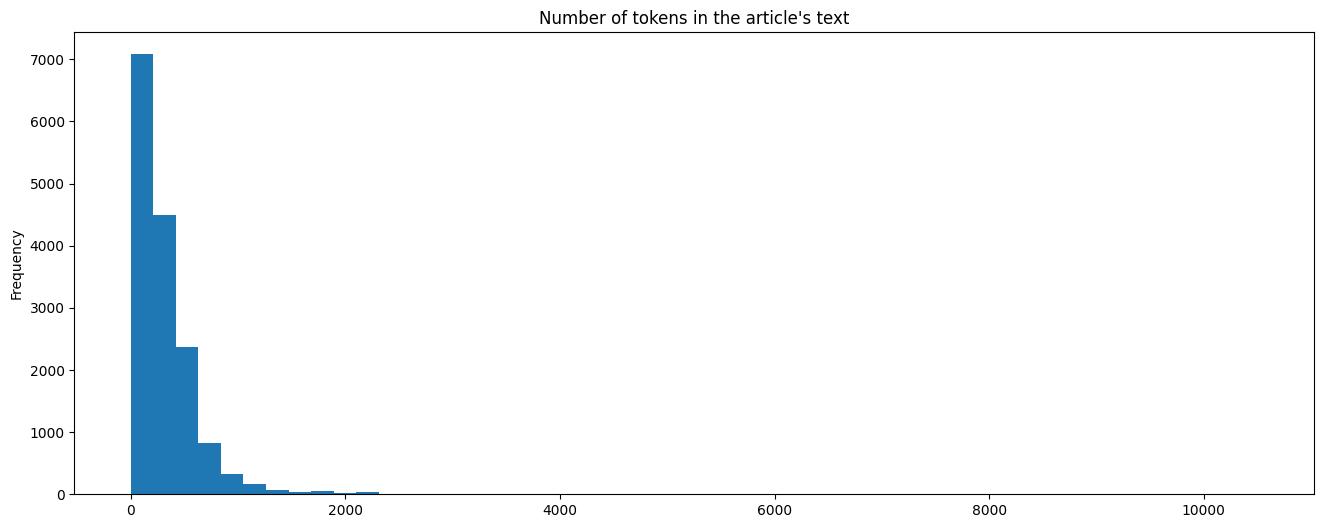

In [38]:
tokens_numbers = df.swifter.apply(lambda row: len(row["vectorized_clean_text"]), axis = 1)

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
tokens_numbers.plot.hist(title="Number of tokens in the article's text", bins=50, ax=ax)
plt.show()

In [39]:
print("Mean number of tokens per article: {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens per article: {}".format(int(np.std(tokens_numbers))))
print("Median of tokens per article: {}".format(int(np.median(tokens_numbers))))


Mean number of tokens per article: 323
Standard deviation of tokens per article: 382
Median of tokens per article: 236


In [40]:
max_tokens = int(np.mean(tokens_numbers) + 2 * np.std(tokens_numbers))

percent_tokens = df[df["vectorized_clean_text"].apply(len) <= max_tokens].shape[0] / df.shape[0]
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens * 100))

Chosen token window: 1088 - Covers 97.36808236808237% of the dataset


In [41]:
max_len_text = max_tokens
df["vectorized_clean_text"] = df.apply(lambda r: pad_array(r["vectorized_clean_text"], max_len_text) , axis=1)

title (truncate, pad)

Pandas Apply:   0%|          | 0/15540 [00:00<?, ?it/s]

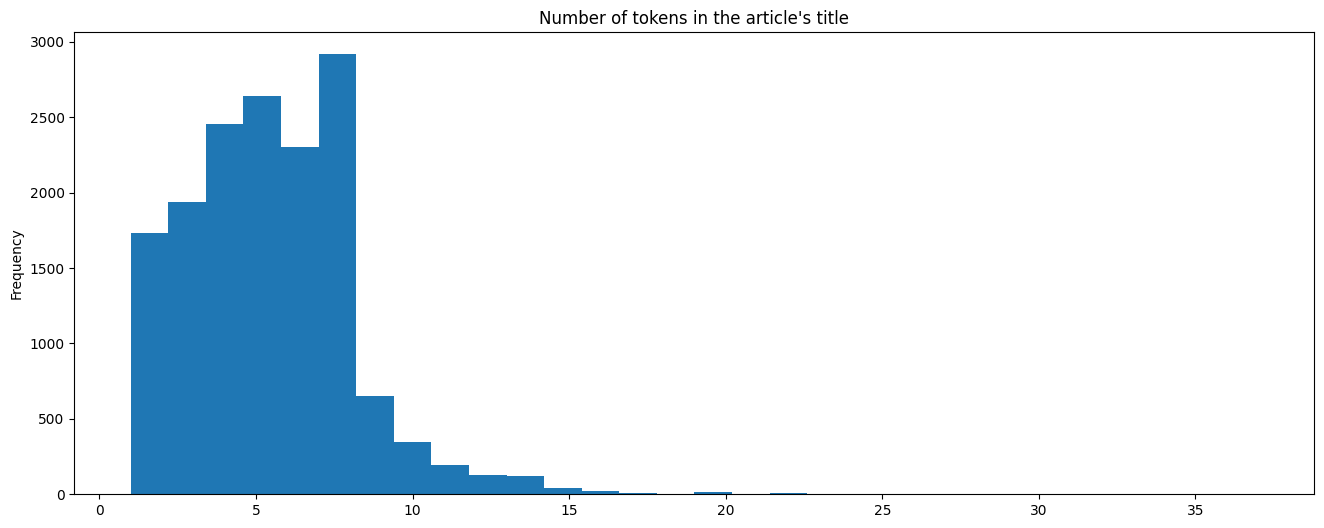

In [42]:
tokens_numbers = df.swifter.apply(lambda row: len(row["vectorized_title"]), axis = 1)

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
tokens_numbers.plot.hist(title="Number of tokens in the article's title", bins=30, ax=ax)
plt.show()

In [43]:
print("Mean number of tokens in the title per article: {}".format(int(np.mean(tokens_numbers))))
print("Standard deviation of tokens in the title per article: {}".format(int(np.std(tokens_numbers))))
print("Median of tokens in the title per article: {}".format(int(np.median(tokens_numbers))))
max_tokens = int(np.mean(tokens_numbers) + 2 * np.std(tokens_numbers))

percent_tokens = df[df["vectorized_title"].apply(len) <= max_tokens].shape[0] / df.shape[0]
print("Chosen token window: {} - Covers {}% of the dataset".format(max_tokens, percent_tokens * 100))

Mean number of tokens in the title per article: 5
Standard deviation of tokens in the title per article: 2
Median of tokens in the title per article: 5
Chosen token window: 10 - Covers 96.45431145431147% of the dataset


In [44]:
max_len_title = max_tokens
df["vectorized_title"] = df.apply(lambda r: pad_array(r["vectorized_title"], max_len_title) , axis=1)

In [45]:
encoder = LabelBinarizer().fit(list(df["type"]))
df["one_hot_label"] = df.apply(lambda r: encoder.transform([r['type']])[0], axis=1)
df.head()

,title,text,type,clean_text,vectorized_clean_text,vectorized_title,one_hot_label
0,properties showcase brand,"They stood in line at Trump Tower, sometimes u...",real,stood line trump tower sometimes half hour han...,"[2379, 318, 25752, 6172, 1631, 242, 957, 7565,...","[2315, 5844, 1449, 0, 0, 0, 0, 0, 0, 0]",[1]
1,trump foundation tells new stopped soliciting ...,Donald J. Trump <U+2019>s foundation informed ...,real,trump us foundation informed attorney general ...,"[25752, 164, 3113, 2826, 1171, 580, 65, 17332,...","[25752, 3113, 2710, 65, 1541, 19799, 111, 555,...",[1]
2,trump prepares white house move tower may still,President-elect Donald J. Trump won the White ...,real,trump white house populist promise prepares as...,"[25752, 1191, 541, 17745, 3102, 8213, 4315, 50...","[25752, 8213, 1191, 541, 408, 6172, 137, 151, ...",[1]
3,luring investors name little else,An investment pitch for a new Texas hotel is t...,real,investment pitch new hotel trying lure invokin...,"[615, 1924, 65, 1639, 469, 8793, 31093, 521, 4...","[22579, 786, 521, 286, 1249, 0, 0, 0, 0, 0]",[1]
4,trump immediately move white house,President-elect Donald J. Trump <U+2019>s wife...,real,trump us wife son immediately move white house...,"[25752, 164, 783, 831, 1045, 408, 1191, 541, 2...","[25752, 1045, 408, 1191, 541, 0, 0, 0, 0, 0]",[1]


In [46]:
print("LABELS")
enc = encoder.transform(encoder.classes_)
for x, y in zip(encoder.classes_, enc):
    print(x, y)

LABELS
fake [0]
real [1]


In [47]:
df["type"].value_counts()

fake    10668
real     4872
Name: type, dtype: int64

In [48]:
label_counts = df['one_hot_label'].apply(tuple).value_counts()
print(label_counts)


(0,)    10668
(1,)     4872
Name: one_hot_label, dtype: int64


In [49]:
df.to_csv("/content/drive/Shareddrives/DS4A_Fakenews/data/clean_data/clean_TI_CNN.csv", encoding='utf-8', index=False)
df.to_pickle("/content/drive/Shareddrives/DS4A_Fakenews/data/clean_data/clean_TI_CNN.pickle")